In [3]:
EXP_NAME = "final"

DEPTH=4 
WF=6 
PADDING=False
BATCH_NORM=True 
UP_MODE="upsample" #"upconv"

LEARNING_RATE = 1e-4 
BETA_1 = 0.95
BETA_2 = 0.99

N_IT = 250000 

print("Number of filters at the top : ", 2**WF)
print("Number of filters at the bottom : ", 2**(WF+DEPTH-1))

Nombre de filtres en haut :  64
Nombre de filtres en bas :  512


# Maximin Affinity Learning of Image Segmentation (MALIS)

In this notebook, we will implement the following paper:
> [ *Large Scale Image Segmentation with Structured Loss Based Deep Learning for Connectome Reconstruction*, J. Funke et al., IEEE Transactions on Pattern Analysis and Machine Intelligence, vol. 41, pp. 1669–1680, July 2019.](https://ieeexplore.ieee.org/document/8364622)

We tried to be as faithful as possible to the method presented in the paper, especially regarding the loss function.
However we made some changes since we worked in 2D due to time constraints for training.

In [2]:
!nvidia-smi

Sun May  3 10:34:49 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
%%capture
!pip install ipywidgets
!pip install higra

import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

import h5py

import skimage.measure

import higra as hg
from higra import HorizontalCutExplorer,HorizontalCutNodes, CptHierarchy


import torchvision.transforms.functional as TF
from torchvision import transforms

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import time

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [0]:
from IPython.display import clear_output

def print_state(net, input_im, Lp, Ln,tot,samples=50):
  #plot preditctions
  fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(22,7))
  Ln_sampled = []
  Lp_sampled = []
  tot_sampled = []
  xs = []
  for i in range(len(Lp) // samples):
      Ln_sampled.append(np.mean(Ln[i*samples:(i+1)*samples]))
      Lp_sampled.append(np.mean(Lp[i*samples:(i+1)*samples]))
      tot_sampled.append(np.mean(tot[i*samples:(i+1)*samples]))
      xs.append(i*samples + samples/2)

  lp, = ax1.plot(xs,Lp_sampled, label="Positive Loss",color="g")

  ax1p = ax1.twinx()

  ln, = ax1p.plot(xs,Ln_sampled, label="Negative Loss") 
  #sol, = ax1p.plot(xs,tot_sampled, label="Sum of losses") 
  #plt.legend(handles=[ln,lp,sol])
  plt.legend(handles=[ln,lp])

  plt.ylim(bottom=0)
  plt.xlim(left=0)
  plt.ylabel("Loss value")
  plt.xlabel("Iteration")
  plt.title("Losses")
  
  
  #Make preds
  input_im = torch.tensor(input_im[0][:512,:512])
  input_im = torch.stack([input_im])
  input_im = torch.stack([input_im])

  input_im = input_im.to(device,dtype=torch.float)
  pred = net(input_im).detach().cpu().numpy()
  pred_x = pred[0][0]
  pred_y = pred[0][1]

  ax2.imshow(pred_x,cmap="gray")
  ax2.axis('off')
  ax2.set_title("Predictions on the x axis")

  ax3.imshow(pred_y,cmap="gray")
  ax3.axis('off')
  ax3.set_title("Predictions on the y axis")
  
  fig.tight_layout()
  clear_output(wait=True)
  plt.show()
  del input_im
  del pred
  del pred_x
  del pred_y



# Hyperparameters

In [0]:
def get_out_size(size,depth):
     for _ in range(depth-1):
         size -=4
         size = size //2
     size -=4
     for _ in range(depth-1):
         size *=2
         size -=4
     return size

In [0]:
EPOCHS = 1000 # 100
BATCH_SIZE = 1 

PATCH_SIZE = 256
OUT_SIZE=get_out_size(PATCH_SIZE,DEPTH)
DELTA = int((PATCH_SIZE - OUT_SIZE) /2)
N_PAIRS = 8
RATIO = 4/5

# Dataset

In this example, we use the [CREMI](https://cremi.org/data/) dataset, and will load directly the hdf file into a PyTorch dataset.
For data augmentation, we will use a custom library that implements elastic transform in an optimised fashion thanks to OpenCV and that uses modified versions of Pytorch's original ones, adapted to our data format.

In [0]:
from custom_lib import *

class CREMIDataset(Dataset):
    """CREMI Dataset"""

    def __init__(self, hdf_file, img_dir, seg_dir, transform=None):
        """
        Args:
            hdf_file (string): Path to the hdf file with the data.
            img_dir (string): Directory with all the images.
            seg_dir (string): Directory with all the associated segmentation.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.hdf = h5py.File(hdf_file, 'r')
        self.img_dir = img_dir
        self.seg_dir = seg_dir
        self.transform = transform
        self.image_shape = self.hdf[self.img_dir][0].shape

    def __len__(self):
        return self.hdf[self.img_dir].shape[0]

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        #Fuse all ndarrays into one and normalize
        image = np.stack([self.hdf[self.img_dir][idx]],axis=0)
        #image = (image/np.max(image)*2)-1
        #image = (image - np.mean(image))/(np.std(image))
        #Change type since original type (uint64) is not supported
        segment = np.stack(self.hdf[self.seg_dir][idx],axis=0).astype(np.int64)

        sample = {'image': image, 'segmentation': segment}

        if self.transform:
            sample = self.transform(sample)
            image = sample["image"].numpy()
            segment = sample["segmentation"]

        
        sample = {'image': (image/np.max(image)*2)-1, 'segmentation': segment}
        return sample

This function will be used to obtain all NxN patches in an image. (256x256 in our case)

The parameter *stride* will be used to get overlapping images. A stride of M will give us an overlap of N-M between our patches

In [0]:
def get_patches_from_image(image,gt_image, patch_size, stride=None):
  if stride == None:
    stride = patch_size
  n_patches = (image.shape[1]-patch_size)//stride + 1
  patches = []
  for i in range(0,image.shape[1]-patch_size,stride):
    for j in range(0,image.shape[1]-patch_size,stride):
          patches.append(image[...,i:i+patch_size,j:j+patch_size])
  return patches

In [0]:
transform = transforms.Compose([
    ElasticTransform(4,10,42),   
    cToPILImage(),
    cColorJitter(brightness=(0.8,1.2),contrast=(0.8,1.2)),
    cRandomVerticalFlip(p=0.2),
    cRandomHorizontalFlip(p=0.2),
    cToTensor()
    ])

In [0]:
filename = '../CREMI datasets/train.hdf' 

dataset = CREMIDataset(filename,'volumes/raw','volumes/labels/neuron_ids',transform=transform)

In [0]:
dataloader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE,shuffle=True, num_workers=1)

# U-net architecture

In [14]:
from unet import UNet
model = UNet(n_classes=2,depth=DEPTH,wf=WF, padding=PADDING, up_mode=UP_MODE, batch_norm=BATCH_NORM).to(device)

net = nn.Sequential(
    model,
    nn.Sigmoid()
)

summary(net, (1,256,256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 254, 254]             640
              ReLU-2         [-1, 64, 254, 254]               0
       BatchNorm2d-3         [-1, 64, 254, 254]             128
            Conv2d-4         [-1, 64, 252, 252]          36,928
              ReLU-5         [-1, 64, 252, 252]               0
       BatchNorm2d-6         [-1, 64, 252, 252]             128
     UNetConvBlock-7         [-1, 64, 252, 252]               0
            Conv2d-8        [-1, 128, 124, 124]          73,856
              ReLU-9        [-1, 128, 124, 124]               0
      BatchNorm2d-10        [-1, 128, 124, 124]             256
           Conv2d-11        [-1, 128, 122, 122]         147,584
             ReLU-12        [-1, 128, 122, 122]               0
      BatchNorm2d-13        [-1, 128, 122, 122]             256
    UNetConvBlock-14        [-1, 128, 1

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2973: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


# Graph weights
This function is used to get the graph corresponding to our NN output.
  * *x[i]* is the value of the edge from i to it's right neigbour
  * *y[i]* is the value of the edge from i to it's top neigbour

In [0]:
def get_weights(x,y):
    height,width=x.shape
    x_u  = x[:-1].T[:-1]
    y_u = y[1:].T

    tot = torch.empty([2*width-1,height-1],device=device)
    tot[0:-1:2,:] = x_u
    tot[1::2,:] = y_u[:-1]
    tot[-1] = y_u[-1]
    tot = torch.cat((tot.T.flatten(),x[-1,:-1]))
    return tot

# Get mask from groundtruth

In [0]:
def get_mask(g,vertex_classes):
  weights = hg.weight_graph(g,vertex_classes.flatten(),hg.WeightFunction.L1)
  weights[weights != 0 ] = 1
  return weights

# Maximin

To calculate the maximin edge value for all pairs of pixels, we will use a binary partition tree as described in [Playing with Kruskal: algorithms formorphological trees in edge-weighted graphs](https://hal.archives-ouvertes.fr/hal-00798621/). This will give us all the necessary data needed to compute the loss.

In [0]:
def relabel(tab):
    #coef = 1/tab.min().type(torch.FloatTensor)
    #tab= (tab*coef).type(torch.IntTensor)
    labeled = skimage.measure.label(tab, background=0, connectivity=1)
    return labeled-1, np.unique(labeled).shape[0]


Here we will use cython for a small bit of code, as it was a major bottleneck during training

In [0]:
%load_ext cython

In [0]:
%%cython
import numpy as np
cimport numpy as np
from cython import wraparound, boundscheck

DTYPE = np.int
ctypedef np.int_t DTYPE_t

#def compute_areas(vertex_labels, left, right, V, k):
@boundscheck(False) # turn off bounds-checking for entire function
def compute_areas(np.ndarray[DTYPE_t, ndim=1] vertex_labels, np.ndarray[DTYPE_t, ndim=1] left, np.ndarray[DTYPE_t, ndim=1] right,DTYPE_t V,DTYPE_t k):
    cdef np.ndarray[DTYPE_t, ndim=2] T = np.zeros((2*V-1,k),dtype=DTYPE)
    cdef int i,j,l,r
    for i in range(0,V):
        T[i,vertex_labels[i]] = 1
    for i in range(V-1):
        for j in range(k):
            T[V+i,j] = T[left[i],j] + T[right[i],j]
    return T

In [0]:
def get_maximin_edges(graph, edge_weights, truth, step):
    V = graph.num_vertices()

    #Relabel our groundtruth for ease of computation
    labeled,k = relabel(truth)
    vertex_weights = labeled.flatten()

    tree, altitudes = hg.bpt_canonical(graph, -edge_weights.detach().numpy())
    mst = hg.get_attribute(tree,"mst")
    mst_map =hg.get_attribute(mst,"mst_edge_map")
   
    #areas 0:|V| = nodes, areas |V|:2|V|-2 = edges
    #CF playing with kruskal
    areas = hg.attribute_area(tree)
    right = tree.child(1)
    left = tree.child(0)

    #Computing the areas of each label k
    T = compute_areas(vertex_weights, left, right, V, k)
     
    for i in range(left.size):
      T[V+i,:] = T[left[i],:] + T[right[i],:]

    wp = np.sum(T[left,:]*T[right,:],axis=1)
    if step == "positive":
      return wp, mst_map
    else:
      wn = areas[right]*areas[left] - wp
      return wn, mst_map

# Loss and optimizer

In [0]:
def l(truth, predicted):
    return (truth-predicted)**2

In [0]:
def positive_loss(wp,affinities,f):
    Lp = torch.from_numpy(wp).to(device)*f(torch.ones(affinities.shape,device=device),affinities)
    return Lp
def negative_loss(wn,affinities,f):
    Ln = torch.from_numpy(wn).to(device)*f(torch.zeros(affinities.shape,device=device),affinities)
    return Ln


In [0]:
optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE, betas=(BETA_1, BETA_2))

# Training

In [0]:
criterion = torch.nn.MSELoss()
losses=[]
losses_p=[]
losses_n=[]
it = 0

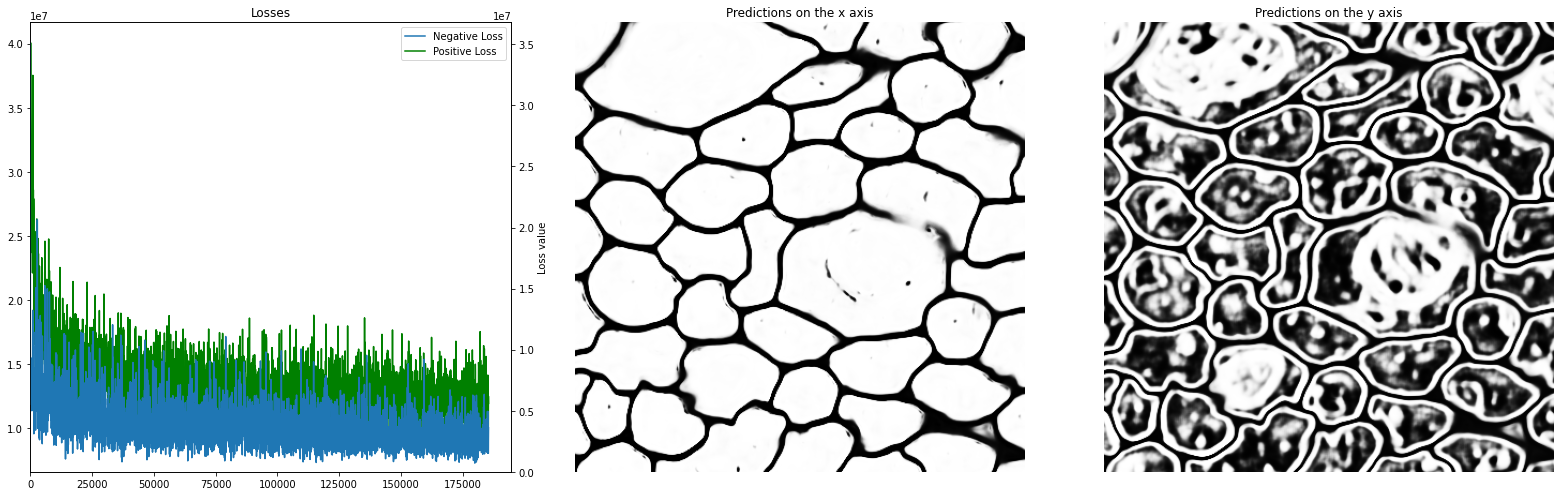

185400 th iteration, avg Lp:  11908468.0  Ln:  3063074.0740001327 time taken:  37.29239106178284 seconds


In [0]:
import cProfile
def train():
  global it
  g = hg.get_4_adjacency_graph((OUT_SIZE,OUT_SIZE))
  start=time.time()
  for epoch in range(EPOCHS): 
    #For each image in the dataset
    for i,image in enumerate(dataloader):
      gt_patches = get_patches_from_image(image["segmentation"][0],image["segmentation"][0],PATCH_SIZE,128)
      for j,patch in enumerate(get_patches_from_image(image["image"][0],image["segmentation"][0],PATCH_SIZE,128)):
        net.zero_grad()

        # crop our groundtruth
        gt = gt_patches[j][DELTA:-DELTA,DELTA:-DELTA]
        #Creating a batch of one for our input
        input_im = torch.stack([patch])
        input_im = input_im.to(device,dtype=torch.float)


        #Making predictioms
        output = net(input_im)
        output_x = output[0,0,:,:]
        output_y = output[0,1,:,:]


       # Retrieving the maximin edge using Higra    
        edge_weights = get_weights(output_x, output_y)
        
        # mask[i] = 0 => Edge is between same object 
        #         = 1 => Edge is between different object
        mask = get_mask(g,gt)
        #=================================
        #        positive pass  
        #=================================
        
        positive_edges = edge_weights.clone().detach() # maybe clone ? 
        # negative edges to 0
        positive_edges[mask==1] = 0 
        # get maximin edges
        wp, mst_map = get_maximin_edges(g, positive_edges.to("cpu"), gt,step="positive")
        mm_positive_values = edge_weights[mst_map]
        Lp = positive_loss(wp,mm_positive_values,l)
 
        #=================================
        #        negative pass  
        #=================================
        negative_edges = edge_weights.clone().detach() # maybe clone ? 
        # negative edges to 0
        negative_edges[mask==0] = 1
        # get maximin edges
        wn, mst_map = get_maximin_edges(g, negative_edges.to("cpu"), gt,step="negative")
        mm_negative_values = edge_weights[mst_map]
        Ln = negative_loss(wn,mm_negative_values,l)

        #=================================
        #        Sum of losses 
        #=================================

        loss = torch.sum(Lp + Ln)


        #print_hist(edge_weights)
        #loss = criterion(gt_patches[j],mm_values,pairs,0)
        losses.append(loss.clone().detach().cpu().numpy())
        losses_p.append(torch.sum(Lp).clone().detach().cpu().numpy())
        losses_n.append(torch.sum(Ln).clone().detach().cpu().numpy())

        # Updating weights
        loss.backward()
        optimizer.step()
        it +=1
        if it % 200 == 0:
          print_state(net, dataset[0]["image"], losses_p, losses_n, losses,samples=50)
          print(it,"th iteration, avg Lp: ", np.mean(losses_p[it-200:it-1])," Ln: ",np.mean(losses_n[it-200:it-1]),  "time taken: ",time.time()-start,"seconds" )
          start= time.time()

        if it%20000 == 0:
          filename = './checkpoints/final_'+str(it)+'.ckpt'
          torch.save({
            'iteration': it,
            'model_state_dict': net.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss_p': losses_p,
            'loss_n': losses_n
            }, filename)

        if it == N_IT:
          torch.save(net.state_dict(), "./models/model_"+EXP_NAME+".pt" )
          np.save("./losses/p_loss_"+EXP_NAME+".npy", np.array(losses_p))
          np.save("./losses/n_loss_"+EXP_NAME+".npy", np.array(losses_n))
          return
       
        del output
        del output_x
        del output_y
        del edge_weights
  return

train()

In [0]:
torch.save(net.state_dict(), "./models/model_"+EXP_NAME+".pt" )
np.save("./losses/p_loss_"+EXP_NAME+".npy", np.array(losses_p))
np.save("./losses/n_loss_"+EXP_NAME+".npy", np.array(losses_n))